In [66]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [76]:
df1 = pd.read_pickle('results__2.pickle').explode('value').reset_index()
df2 = pd.read_pickle('results_2.pickle').explode('value').reset_index()
df3 = pd.read_pickle('results__3.pickle').explode('value').reset_index()

In [87]:
df3.algorithm.unique()

array(['SKLearn-LR', 'SKLearn-MLP', 'MLP-v0'], dtype=object)

In [90]:
df[(df.subject == subject) & (df.measure_type == 'auc_train') & (df.algorithm == 'SKLearn-MLP')]

,index,measure_type,value,algorithm,subject,encoding,features,random_state,max_iter,verbose,solver,C,hidden_layer_sizes,alpha,batch_size,learning_rate_init,validation_fraction,tol,n_iter_no_change,bins
18,3,auc_train,86.79269,SKLearn-MLP,2261,oh,574,NaN,100,NaN,NaN,NaN,"(4, 7)",1e-06,1000,0.001,0.1,0.0001,10,NaN
19,3,auc_train,86.716511,SKLearn-MLP,2261,oh,574,NaN,100,NaN,NaN,NaN,"(4, 7)",1e-06,1000,0.001,0.1,0.0001,10,NaN
49,14,auc_train,49.998109,SKLearn-MLP,2261,agge,298,NaN,100,NaN,NaN,NaN,"(4, 7)",1e-06,1000,0.001,0.1,0.0001,10,110
50,14,auc_train,75.236584,SKLearn-MLP,2261,agge,298,NaN,100,NaN,NaN,NaN,"(4, 7)",1e-06,1000,0.001,0.1,0.0001,10,110
51,14,auc_train,80.810166,SKLearn-MLP,2261,agge,298,NaN,100,NaN,NaN,NaN,"(4, 7)",1e-06,1000,0.001,0.1,0.0001,10,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,789,auc_train,88.475092,SKLearn-MLP,2261,oh,576,NaN,100,NaN,NaN,NaN,"(32, 7)",0.01,1000,0.001,0.1,0.0001,10,NaN
1948,800,auc_train,83.460308,SKLearn-MLP,2261,agge,294,NaN,100,NaN,NaN,NaN,"(32, 7)",0.01,1000,0.001,0.1,0.0001,10,110
1956,808,auc_train,79.473574,SKLearn-MLP,2261,oh,577,NaN,100,NaN,NaN,NaN,"(32, 7)",0.01,1000,0.001,0.1,0.0001,10,NaN
1964,816,auc_train,82.243751,SKLearn-MLP,2261,agge,296,NaN,100,NaN,NaN,NaN,"(32, 7)",0.01,1000,0.001,0.1,0.0001,10,110


,index,measure_type,value,algorithm,subject,encoding,features,random_state,max_iter,verbose,solver,C,hidden_layer_sizes,alpha,batch_size,learning_rate_init,validation_fraction,tol,n_iter_no_change,bins
0,0,auc_train,83.869241,SKLearn-LR,2261,oh,574,0,10000,1,lbfgs,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,auc_train,83.910132,SKLearn-LR,2261,oh,574,0,10000,1,lbfgs,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,auc_train,83.8584,SKLearn-LR,2261,oh,574,0,10000,1,lbfgs,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,auc_train,83.845978,SKLearn-LR,2261,oh,574,0,10000,1,lbfgs,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,auc_train,83.876545,SKLearn-LR,2261,oh,574,0,10000,1,lbfgs,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,2426,auc_train,55.2341,MLP-v0,2997,agge,232,NaN,100,NaN,NaN,NaN,"(32, 7)",0.01,1000,0.001,0.1,0.0001,10,110
5936,2427,auc_test,51.113878,MLP-v0,2997,agge,232,NaN,100,NaN,NaN,NaN,"(32, 7)",0.01,1000,0.001,0.1,0.0001,10,110
5937,2428,auc_best_model_test,51.113878,MLP-v0,2997,agge,232,NaN,100,NaN,NaN,NaN,"(32, 7)",0.01,1000,0.001,0.1,0.0001,10,110
5938,2429,auc_best_model_train,55.2341,MLP-v0,2997,agge,232,NaN,100,NaN,NaN,NaN,"(32, 7)",0.01,1000,0.001,0.1,0.0001,10,110


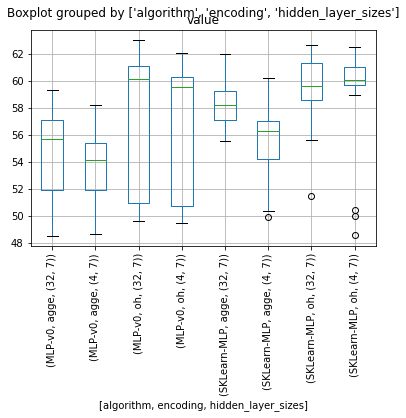

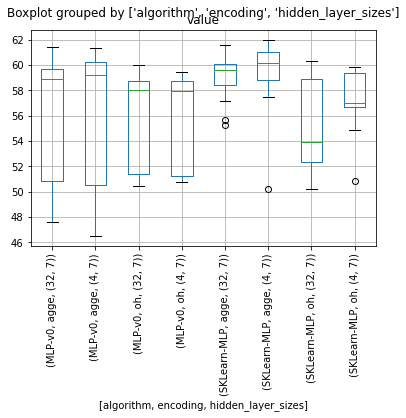

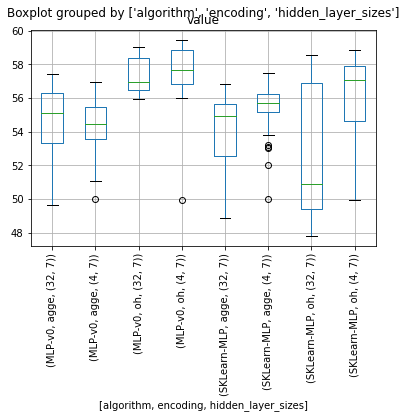

In [111]:
df = df3
df.alpha = df.alpha.astype('double')
df.loc[df.alpha.isna(), "alpha"] = df.loc[df.alpha.isna(), "C"]
for subject in df.subject.unique():
    df[(df.subject == subject) & (df.measure_type == 'auc_test')].sort_values('alpha')\
    .boxplot(column='value', by=['algorithm', 'encoding',  "hidden_layer_sizes"])
    plt.xticks(rotation=90)


In [77]:
df.algorithm.unique()


array(['MLP-v0', 'SKLearn-LR', 'SKLearn-MLP'], dtype=object)

858


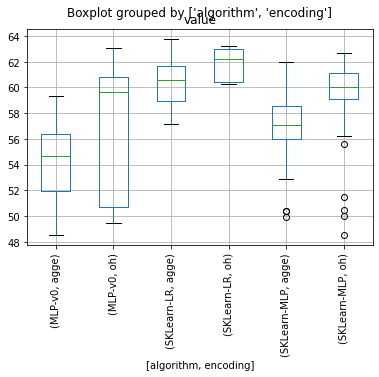

In [75]:
df['description'] = df['algorithm'] + ' ' + df['encoding']
__df1 = df2#[df.algorithm == 'SKLearn-LR']
__df2 = df2#[df.algorithm == 'SKLearn-LR']

# algo[(algo.measure_type == 'auc_train') & (algo.subject == '2259')]\
# .boxplot(column='value', by=['algorithm', 'encoding'])
# plt.xticks(rotation=90)

# algo[(algo.measure_type == 'auc_train') & (algo.subject == '3476')]\
# .boxplot(column='value', by=['algorithm', 'encoding'])
# plt.xticks(rotation=90)


__df_a = __df1[(__df1.encoding == 'oh') & (__df1.measure_type == 'auc_test')]
__df_b = __df2[(__df2.encoding == 'agge') & (__df2.measure_type == 'auc_test')]
__df = __df_a.append(__df_b)
__df[(__df.measure_type == 'auc_test') & (__df.subject == '2261')]\
.boxplot(column='value', by=['algorithm', 'encoding'])
plt.xticks(rotation=90)

print(__df.shape[0])
# algo[(algo.measure_type == 'auc_test') & (algo.subject == '3476')]\
# .boxplot(column='value', by=['algorithm', 'encoding'])
# plt.xticks(rotation=90)


In [35]:
df.algorithm.unique()

array(['MLP-v0', 'SKLearn-LR', 'SKLearn-MLP'], dtype=object)

In [36]:
algo = df[df.algorithm == 'SKLearn-MLP']
algo

# algo[(algo.measure_type == 'auc_train') & (algo.subject == '2259')]\

,index,measure_type,value,algorithm,subject,encoding,features,bins,hidden_layer_sizes,alpha,batch_size,learning_rate_init,max_iter,validation_fraction,tol,n_iter_no_change,random_state,verbose,solver,C,description
47,8,auc_train,77.37744,SKLearn-MLP,3476,oh,562,NaN,"(4, 7)",1e-06,1000,0.001,100,0.1,0.0001,10,NaN,NaN,NaN,NaN,SKLearn-MLP oh
48,8,auc_train,76.194696,SKLearn-MLP,3476,oh,562,NaN,"(4, 7)",1e-06,1000,0.001,100,0.1,0.0001,10,NaN,NaN,NaN,NaN,SKLearn-MLP oh
49,9,auc_test,60.968762,SKLearn-MLP,3476,oh,562,NaN,"(4, 7)",1e-06,1000,0.001,100,0.1,0.0001,10,NaN,NaN,NaN,NaN,SKLearn-MLP oh
50,9,auc_test,61.52585,SKLearn-MLP,3476,oh,562,NaN,"(4, 7)",1e-06,1000,0.001,100,0.1,0.0001,10,NaN,NaN,NaN,NaN,SKLearn-MLP oh
51,10,delta,23.826734,SKLearn-MLP,3476,oh,562,NaN,"(4, 7)",1e-06,1000,0.001,100,0.1,0.0001,10,NaN,NaN,NaN,NaN,SKLearn-MLP oh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,1059,auc_train,77.099699,SKLearn-MLP,2259,oh,189,NaN,"(32, 7)",0.01,1000,0.001,100,0.1,0.0001,10,NaN,NaN,NaN,NaN,SKLearn-MLP oh
3946,1060,auc_test,67.285895,SKLearn-MLP,2259,oh,189,NaN,"(32, 7)",0.01,1000,0.001,100,0.1,0.0001,10,NaN,NaN,NaN,NaN,SKLearn-MLP oh
3947,1060,auc_test,68.26183,SKLearn-MLP,2259,oh,189,NaN,"(32, 7)",0.01,1000,0.001,100,0.1,0.0001,10,NaN,NaN,NaN,NaN,SKLearn-MLP oh
3948,1061,delta,17.983871,SKLearn-MLP,2259,oh,189,NaN,"(32, 7)",0.01,1000,0.001,100,0.1,0.0001,10,NaN,NaN,NaN,NaN,SKLearn-MLP oh


In [38]:
df.measure_type.unique()

array(['auc_train', 'auc_test', 'auc_best_model_test',
       'auc_best_model_train', 'delta'], dtype=object)